In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scvelo as scv
import torch
import torch.nn as nn
from torchdiffeq import odeint
import pandas as pd
import scipy.stats as stats


In [6]:
import pickle 
with open('erythroid_data_dic.pkl', 'rb') as f:
    dic = pickle.load(f)

In [7]:
df = dic["Abcg2"]

In [8]:
# Extract initial state for E7.0
initial_state_df = df.loc['E7.0']
initial_state = torch.tensor(initial_state_df.to_numpy().flatten(), dtype=torch.float32)

# Extract ground truth states for subsequent stages
# Assuming stages are ordered and indexed as in your example
unique_stages = df.index.get_level_values('stage').unique().tolist()
ground_truth_states = []

for stage in unique_stages[1:]:  # Skip E7.0 since it's our initial state
    stage_df = df.loc[stage]
    stage_state = torch.tensor(stage_df.to_numpy().flatten(), dtype=torch.float32)
    ground_truth_states.append(stage_state)

ground_truth_states = torch.stack(ground_truth_states)

# Data preparation
initial_state_df = df.loc['E7.0']
initial_state = torch.tensor(initial_state_df.to_numpy().flatten(), dtype=torch.float32)

unique_stages = df.index.get_level_values('stage').unique().tolist()
ground_truth_states = []
for stage in unique_stages[1:]:  # Skip E7.0
    stage_df = df.loc[stage]
    stage_state = torch.tensor(stage_df.to_numpy().flatten(), dtype=torch.float32)
    ground_truth_states.append(stage_state)

ground_truth_states = torch.stack(ground_truth_states)

# Now `initial_state` and `ground_truth_states` are ready for use in the neural ODE model
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 50),  # 10 states = 5 means + 5 stds, adjust sizes as needed
            nn.Tanh(),
            nn.Linear(50, 10)   # Output: rate of change for the 10 states
        )

    def forward(self, t, y):
        return self.net(y)

# Prepare your data
# For this example, you would need to transform your DataFrame into a suitable format
# Assume `initial_state` is a tensor of shape [10] (5 means + 5 stds at E7.0)
# Assume `ground_truth_states` is a tensor of shape [time_steps, 10] representing the subsequent stages

# Define the model
func = ODEFunc()
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)
time_span = torch.tensor([0, 1.0])  # Simulation time span
timesteps = torch.linspace(time_span[0], time_span[1], steps=ground_truth_states.shape[0])  # More fine-grained time steps for the simulation

#ground_truth_times = torch.linspace(0, 1, steps=ground_truth_states.shape[0])


# Training loop
for epoch in range(1000):  # Adjust epochs as needed
    optimizer.zero_grad()
    
    # Predict the trajectory
    pred_states = odeint(func, initial_state, t=timesteps)
    
    # Compute loss
    loss = torch.mean((pred_states - ground_truth_states) ** 2)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Note: This code is highly simplified and needs to be adjusted based on your actual dataset and model requirements.



Epoch 0, Loss: 0.7271743416786194
Epoch 100, Loss: 0.161764994263649
Epoch 200, Loss: 0.15061801671981812
Epoch 300, Loss: 0.14079803228378296
Epoch 400, Loss: 0.1373012512922287
Epoch 500, Loss: 0.13376334309577942
Epoch 600, Loss: 0.12982971966266632
Epoch 700, Loss: 0.12660923600196838
Epoch 800, Loss: 0.12516175210475922
Epoch 900, Loss: 0.1247139722108841


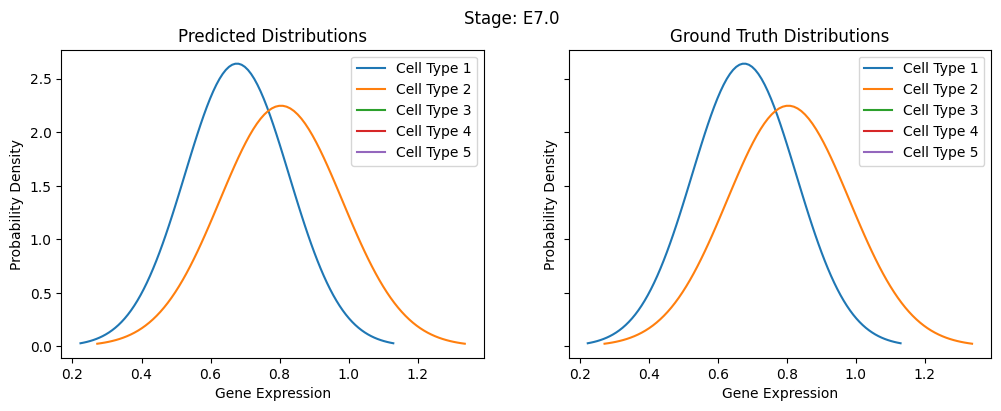

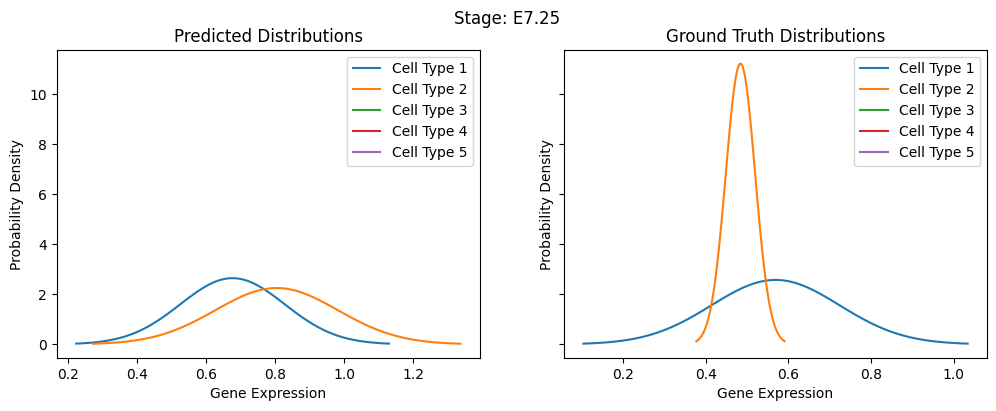

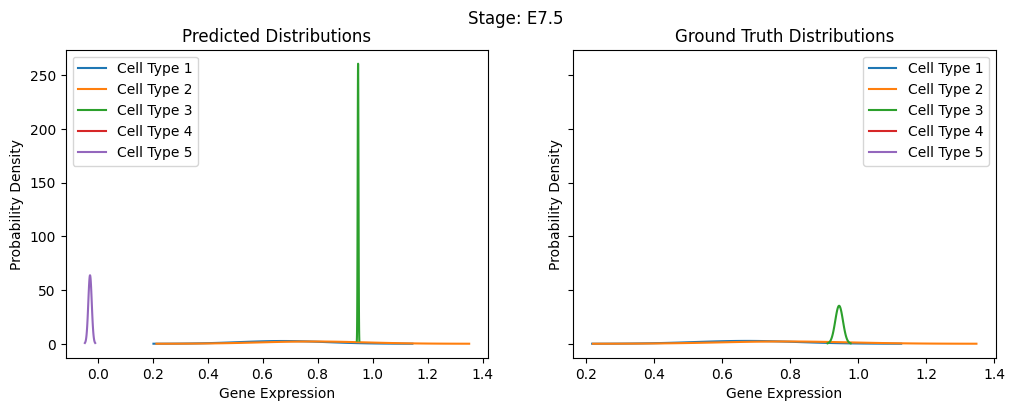

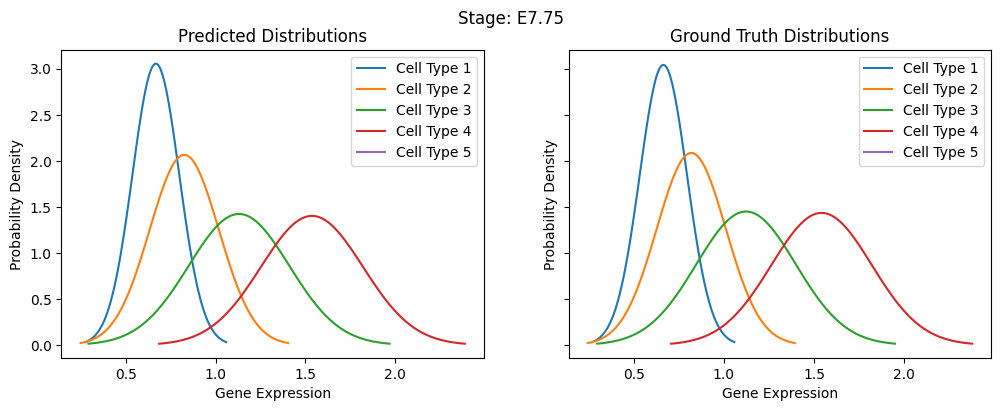

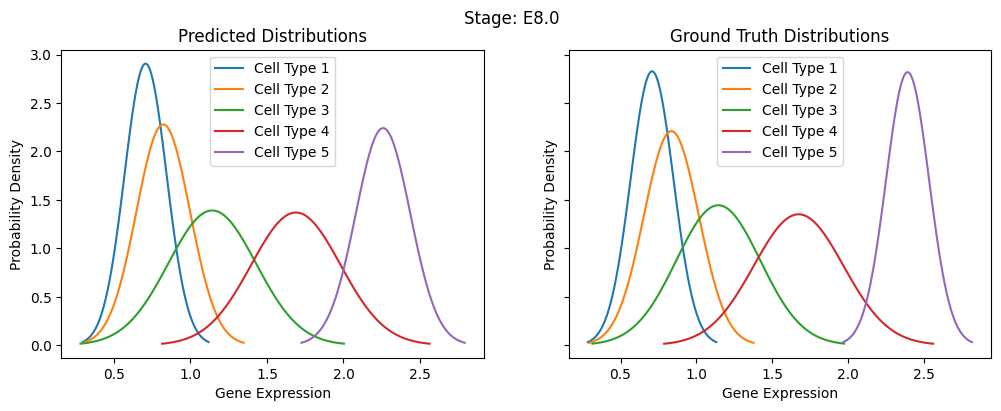

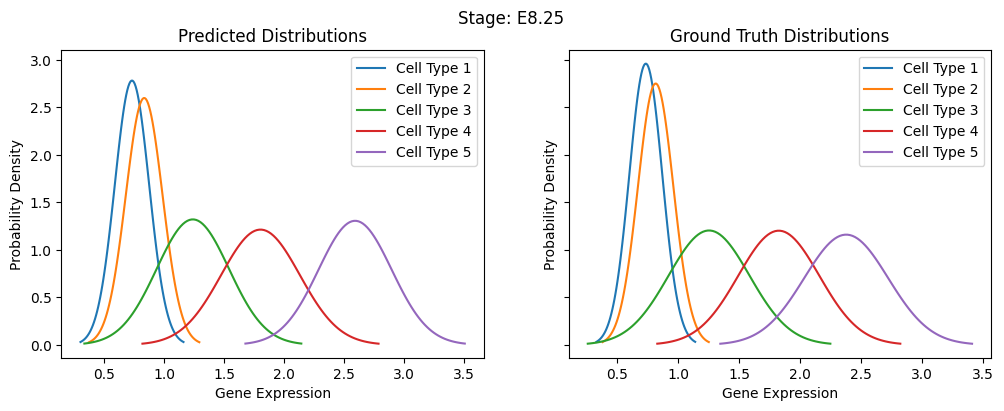

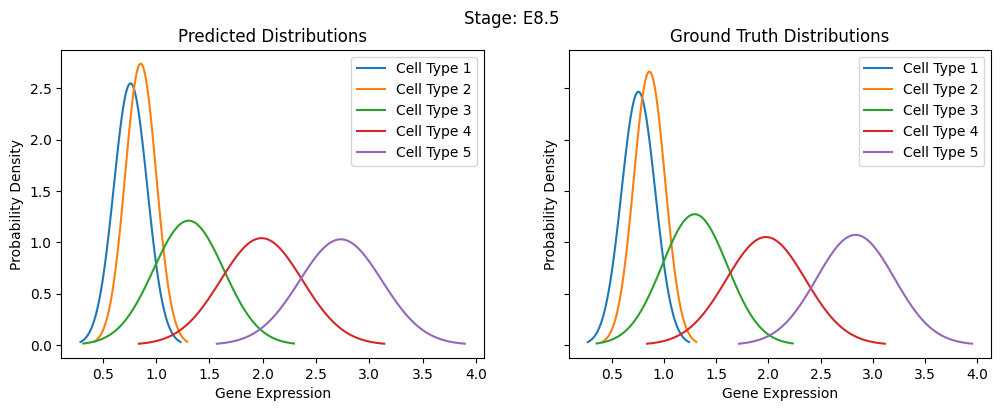

In [9]:
# Prepend the initial state to pred_states for comparison, if not already included
pred_states_with_initial = torch.cat([initial_state.unsqueeze(0), pred_states], 0)
# Ensure "E7.0" is included at the start of your stages list
unique_stages = ['E7.0'] + unique_stages[1:]  # Adjust if "E7.0" is not already included


def plot_distributions(stage_idx, stage, pred_state, ground_truth_state, cell_types):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    fig.suptitle(f'Stage: {stage}')
    
    for ax, state, title in zip(axs, [pred_state, ground_truth_state], ['Predicted', 'Ground Truth']):
        ax.set_title(f'{title} Distributions')
        for i, cell_type in enumerate(cell_types):
            mean = state[i * 2]  # Assuming means are in even indices
            std = state[i * 2 + 1]  # Assuming stds are in odd indices
            x = np.linspace(mean - 3*std, mean + 3*std, 100)
            y = stats.norm.pdf(x, mean, std)
            ax.plot(x, y, label=f'Cell Type {i+1}')
        ax.legend()
        ax.set_xlabel('Gene Expression')
        ax.set_ylabel('Probability Density')
        plt.xlim()

# Assuming cell_types is a list of your cell types
cell_types = ['Blood progenitors 1', 'Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']

# Simulate a prediction for demonstration (replace with your actual pred_states from the model)
#pred_states = torch.randn_like(ground_truth_states)  # Random prediction for demonstration

# Adjusted plotting loop to include initial state
for stage_idx, stage in enumerate(unique_stages):  # Now includes E7.0
    if stage == 'E7.0':
        # For initial state, compare the initial_state with itself as ground truth
        ground_truth_state = initial_state.detach().numpy()
        pred_state = pred_states_with_initial[0].detach().numpy()
    else:
        # For subsequent stages, fetch from ground_truth_states and pred_states_with_initial
        ground_truth_state = ground_truth_states[stage_idx - 1].detach().numpy()  # Offset by 1 due to initial state
        pred_state = pred_states_with_initial[stage_idx].detach().numpy()

    plot_distributions(stage_idx, stage, pred_state, ground_truth_state, cell_types)



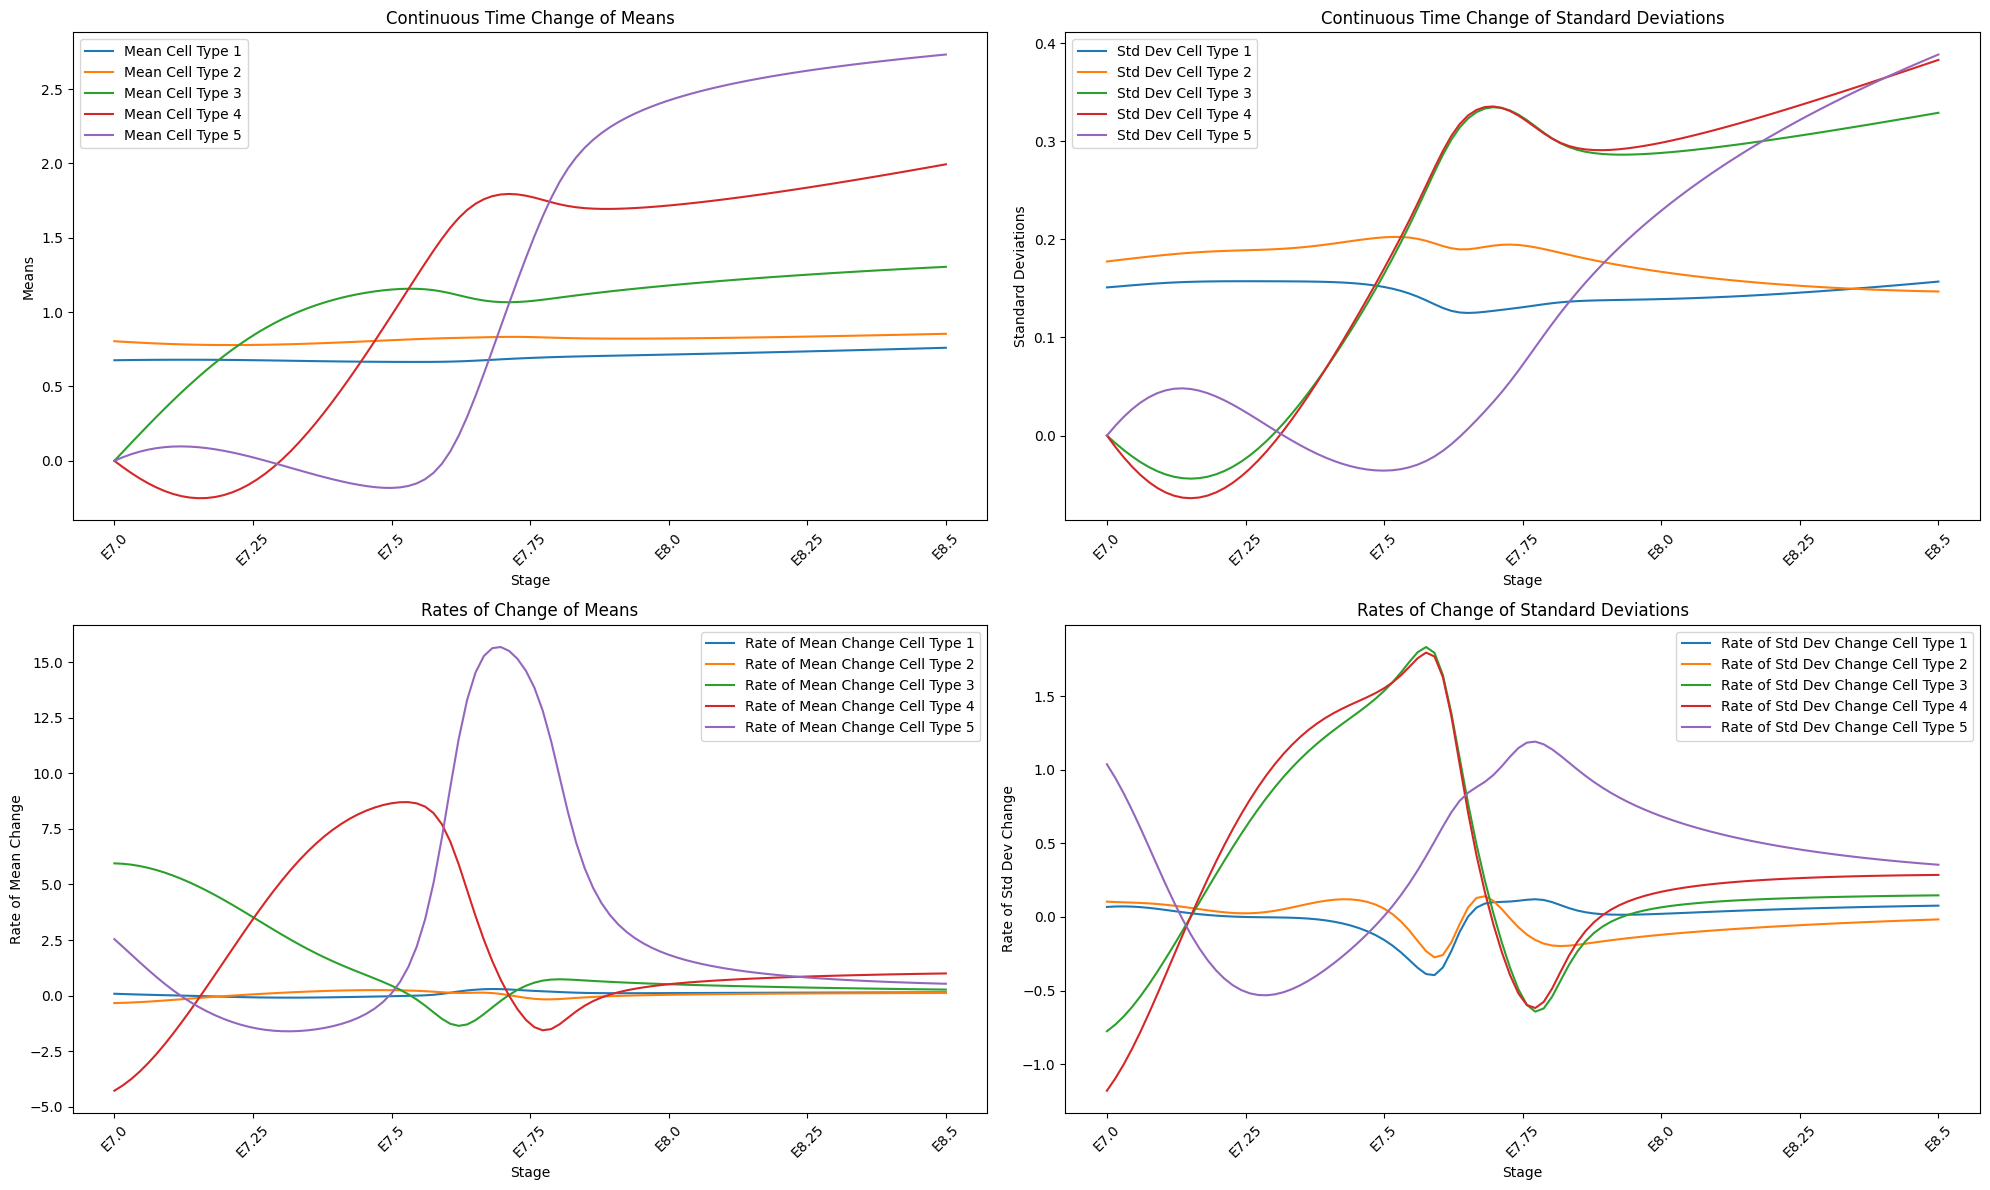

In [16]:
# Assuming your trained model 'func' and 'initial_state' are defined
fine_timesteps = torch.linspace(0, 1.0, steps=100)  # Example: 100 fine-grained steps

# Compute the states over these fine-grained timesteps using the trained model
fine_pred_states = odeint(func, initial_state, fine_timesteps)


# Example mapping: Assume we know the indices in fine_timesteps that correspond to each stage
stage_indices = np.linspace(0,1,ground_truth_states.shape[0]+1)  # Example indices corresponding to stages in fine_timesteps
stage_labels = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']  # Example stage labels

# Initialize a list to hold the rates of change
rates_of_change = []

# Compute the rate of change at each fine-grained timestep
for i, t in enumerate(fine_timesteps):
    state_at_t = fine_pred_states[i]
    rate_of_change_at_t = func(t, state_at_t)
    rates_of_change.append(rate_of_change_at_t)

# Convert the list of tensors to a tensor
rates_of_change = torch.stack(rates_of_change)


fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Helper function to set stage labels on x-axis
def set_stage_labels(ax, indices, labels):
    ax.set_xticks(indices)
    ax.set_xticklabels(labels, rotation=45)  # Rotate labels for better readability

# Plot the same data as before, adjusting for stage labels
for i in range(0, 10, 2):  # Assuming even indices are means
    axs[0, 0].plot(fine_timesteps.numpy(), fine_pred_states.detach().numpy()[:, i], label=f'Mean Cell Type {i//2 + 1}')
set_stage_labels(axs[0, 0], stage_indices, stage_labels)
axs[0, 0].set_title('Continuous Time Change of Means')
axs[0, 0].set_xlabel('Stage')
axs[0, 0].set_ylabel('Means')
axs[0, 0].legend()


for i in range(1, 10, 2):  # Assuming odd indices are standard deviations
    axs[0, 1].plot(fine_timesteps.numpy(), fine_pred_states.detach().numpy()[:, i], label=f'Std Dev Cell Type {(i-1)//2 + 1}')
set_stage_labels(axs[0, 1], stage_indices, stage_labels)
axs[0, 1].set_title('Continuous Time Change of Standard Deviations')
axs[0, 1].set_xlabel('Stage')
axs[0, 1].set_ylabel('Standard Deviations')
axs[0, 1].legend()


for i in range(0, 10, 2):
    axs[1, 0].plot(fine_timesteps.numpy(), rates_of_change.detach().numpy()[:, i], label=f'Rate of Mean Change Cell Type {i//2 + 1}')
set_stage_labels(axs[1, 0], stage_indices, stage_labels)
axs[1, 0].set_title('Rates of Change of Means')
axs[1, 0].set_xlabel('Stage')
axs[1, 0].set_ylabel('Rate of Mean Change')
axs[1, 0].legend()


for i in range(1, 10, 2):
    axs[1, 1].plot(fine_timesteps.numpy(), rates_of_change.detach().numpy()[:, i], label=f'Rate of Std Dev Change Cell Type {(i-1)//2 + 1}')
set_stage_labels(axs[1, 1], stage_indices, stage_labels)
axs[1, 1].set_title('Rates of Change of Standard Deviations')
axs[1, 1].set_xlabel('Stage')
axs[1, 1].set_ylabel('Rate of Std Dev Change')
axs[1, 1].legend()



plt.tight_layout()
plt.show()


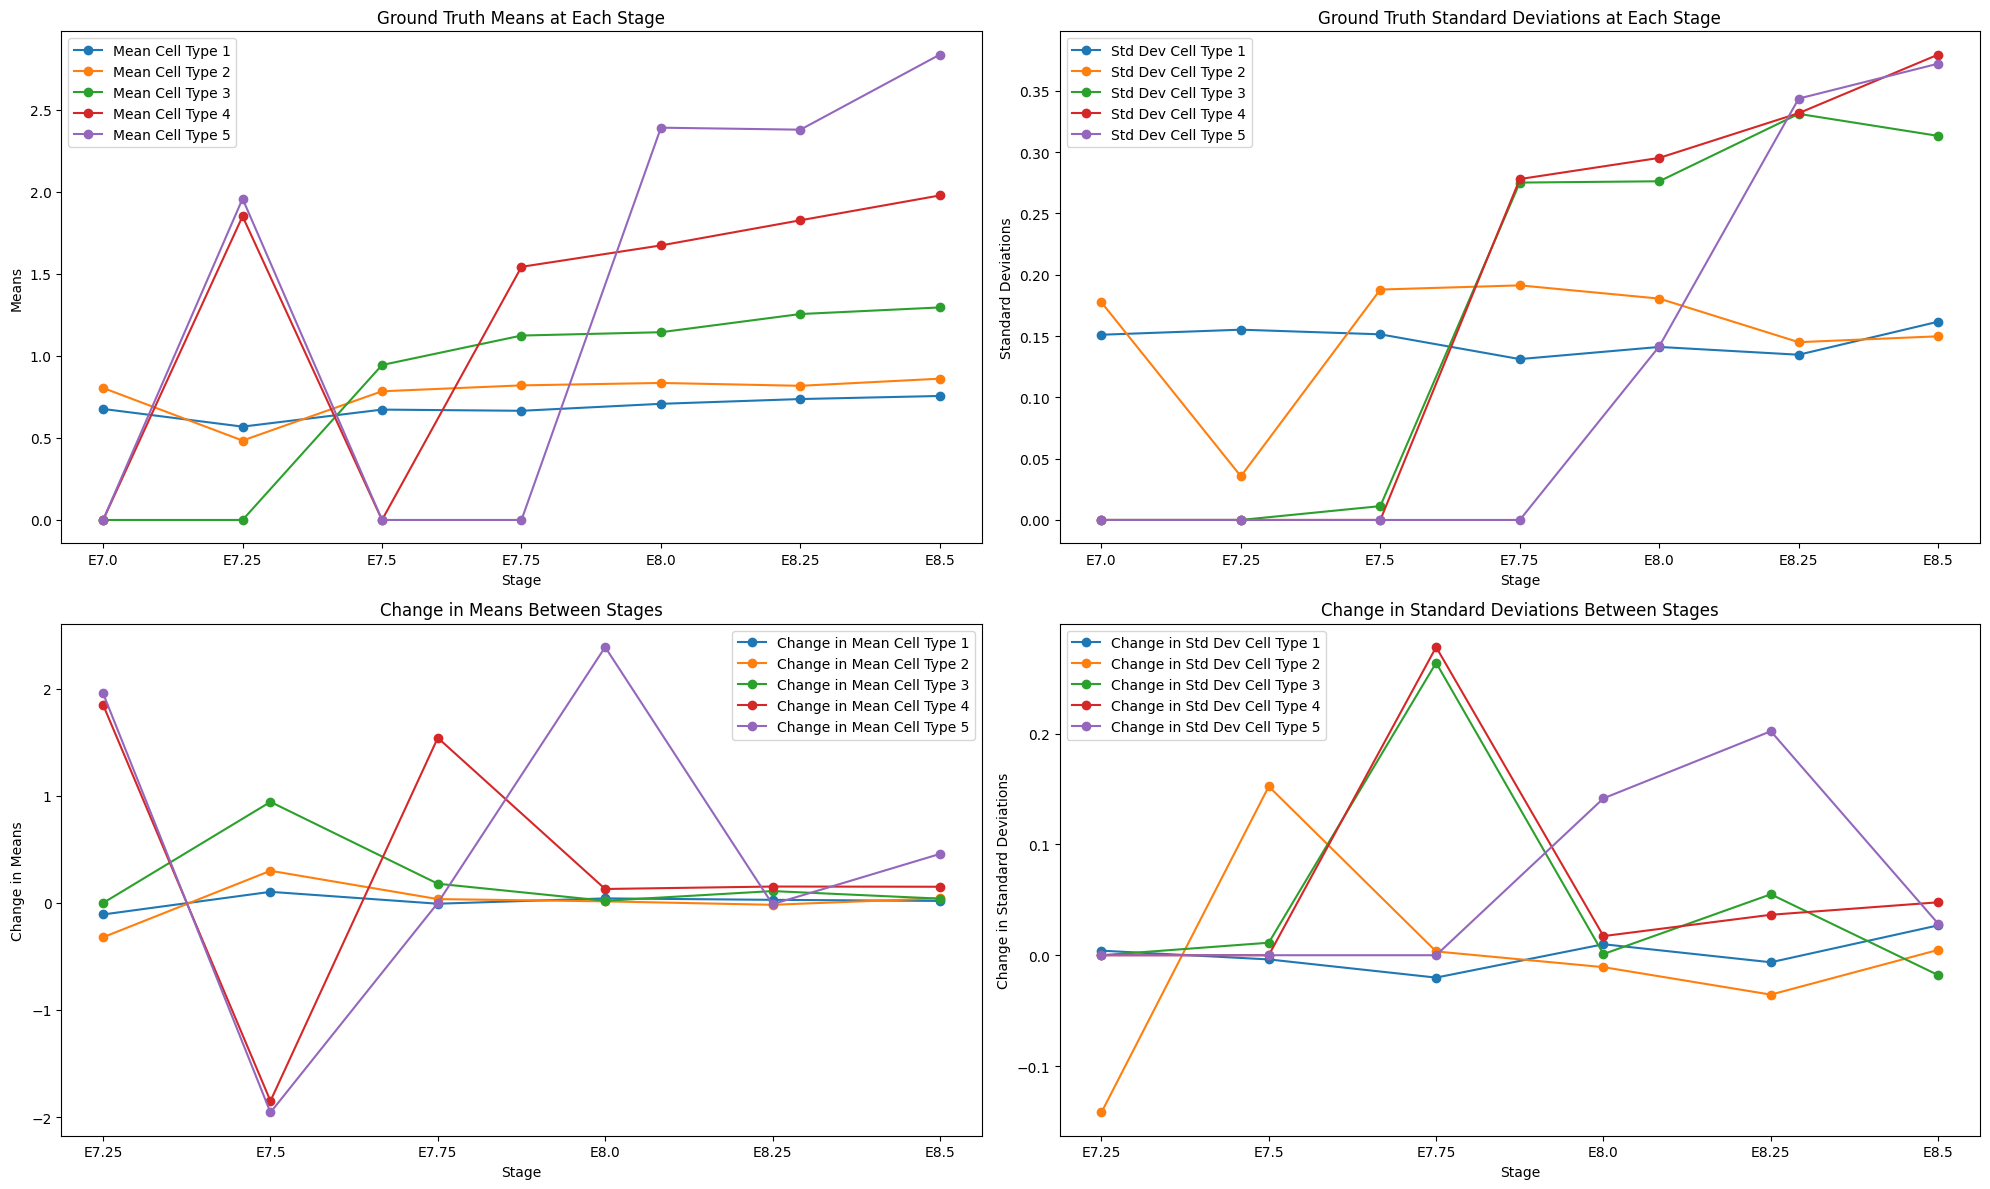

In [13]:
# Assuming initial_state and ground_truth_states are already defined
# Ensure initial_state is reshaped correctly if it's not already a 2D tensor with a single row
initial_state_reshaped = initial_state.unsqueeze(0)  # Adds a batch dimension if it's not present

# Concatenate the initial state with the rest of the ground truth states
# Since initial_state represents E7.0, it should be the first entry
ground_truth_states_with_initial = torch.cat([initial_state_reshaped, ground_truth_states], dim=0).detach().numpy()
# Calculate differences between successive states for means and standard deviations
# The difference calculation ignores the first row (initial state) since it has no preceding state to compare
diff_means = np.diff(ground_truth_states_with_initial[:, ::2], axis=0)  # ::2 skips to every other column starting from 0 (means)
diff_stds = np.diff(ground_truth_states_with_initial[:, 1::2], axis=0)  # 1::2 skips to every other column starting from 1 (stds)

fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # 2 rows, 2 columns

# Plotting the ground truth states (means and stds) against stages
# Ground truth means
for i in range(diff_means.shape[1]):
    axs[0, 0].plot(stage_labels, ground_truth_states_with_initial[:, i*2], '-o', label=f'Mean Cell Type {i+1}')
axs[0, 0].set_title('Ground Truth Means at Each Stage')
axs[0, 0].set_xlabel('Stage')
axs[0, 0].set_ylabel('Means')
axs[0, 0].legend()

# Ground truth stds
for i in range(diff_stds.shape[1]):
    axs[0, 1].plot(stage_labels, ground_truth_states_with_initial[:, i*2+1], '-o', label=f'Std Dev Cell Type {i+1}')
axs[0, 1].set_title('Ground Truth Standard Deviations at Each Stage')
axs[0, 1].set_xlabel('Stage')
axs[0, 1].set_ylabel('Standard Deviations')
axs[0, 1].legend()

# Plotting the differences (changes) in means and stds between successive stages
# Changes in means
for i in range(diff_means.shape[1]):
    axs[1, 0].plot(stage_labels[1:], diff_means[:, i], '-o', label=f'Change in Mean Cell Type {i+1}')
axs[1, 0].set_title('Change in Means Between Stages')
axs[1, 0].set_xlabel('Stage')
axs[1, 0].set_ylabel('Change in Means')
axs[1, 0].legend()

# Changes in stds
for i in range(diff_stds.shape[1]):
    axs[1, 1].plot(stage_labels[1:], diff_stds[:, i], '-o', label=f'Change in Std Dev Cell Type {i+1}')
axs[1, 1].set_title('Change in Standard Deviations Between Stages')
axs[1, 1].set_xlabel('Stage')
axs[1, 1].set_ylabel('Change in Standard Deviations')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


